# Project aim: 
To estimate the likely permissible loan amount for a client

# Data library:
1. Loan_ID - Unique loan request identifier - String,
2. Gender - sex of the user  -  String,
3. Married,
4. Dependents,
5. Education,
6. Self_Employed,
7. ApplicantIncome,
8. CoapplicantIncome,
9. LoanAmount,
10. Loan_Amount_Term - in months - integer,
11. Credit_History - 1(okay or eligible),0(Not eligible) - Integer,
12. Property_Area,
13. Loan_Status

# Steps covered in the notebook
1. EDA
2. Feature engineering and selection
3. Model training
4. Model evalution
5. Feature engineering pipeline
6. Final model pipeline


Load and Preprocess data

In [1]:
# importing necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor, ElasticNet, LassoCV
from feature_engine.encoding import OrdinalEncoder

# experiment tracking
import  mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

import seaborn as sns 
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('loan-amount-train.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
# formatting colum names and data for consistency
data.columns = data.columns.str.lower()

In [5]:
# drop the ID, gender and loan status columns as they are irrelevant to our modeling
df = data.drop(['loan_id', 'gender', 'loan_status'], axis=1)
print('original data shape: {} , new data shape:{} '.format(data.shape, df.shape))

original data shape: (614, 13) , new data shape:(614, 10) 


(array([ 72., 310., 143.,  33.,  15.,   6.,   5.,   3.,   3.,   2.]),
 array([  9. ,  78.1, 147.2, 216.3, 285.4, 354.5, 423.6, 492.7, 561.8,
        630.9, 700. ]),
 <BarContainer object of 10 artists>)

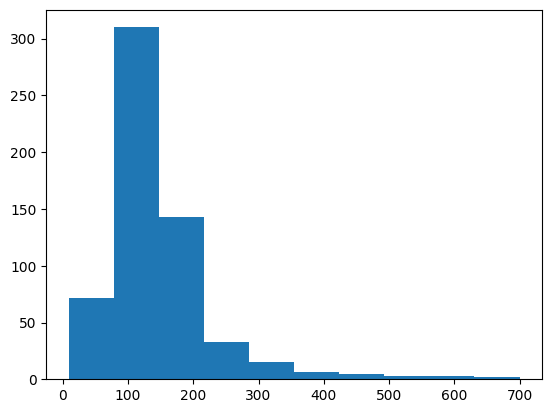

In [6]:
# explore distribution of the target variable loanamount
plt.hist(df['loanamount'], bins =10)

(array([  1.,   1.,   5.,  17.,  60., 211., 211.,  56.,  18.,  12.]),
 array([2.30258509, 2.72757737, 3.15256965, 3.57756193, 4.00255421,
        4.42754649, 4.85253877, 5.27753105, 5.70252333, 6.12751561,
        6.55250789]),
 <BarContainer object of 10 artists>)

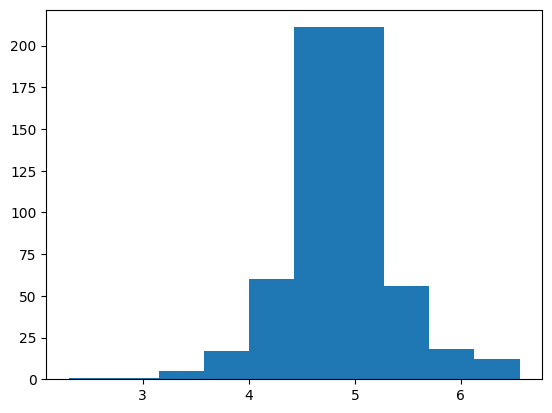

In [7]:
# taking the log of our target variable, since a highly skewed data can impact our model
target  = np.log1p(df['loanamount'])
plt.hist(target, bins =10)

In [8]:
list(target)

[nan,
 4.859812404361672,
 4.204692619390966,
 4.795790545596741,
 4.955827057601261,
 5.5909869805108565,
 4.564348191467836,
 5.0689042022202315,
 5.1298987149230735,
 5.857933154483459,
 4.2626798770413155,
 4.700480365792417,
 5.303304908059076,
 4.74493212836325,
 2.8903717578961645,
 4.836281906951478,
 4.61512051684126,
 4.343805421853684,
 4.897839799950911,
 4.7535901911063645,
 4.653960350157523,
 5.755742213586912,
 4.762173934797756,
 4.727387818712341,
 5.0238805208462765,
 5.2574953720277815,
 4.812184355372417,
 4.709530201312334,
 3.58351893845611,
 4.795790545596741,
 5.308267697401205,
 4.31748811353631,
 4.672828834461906,
 4.74493212836325,
 5.771441123130016,
 nan,
 4.61512051684126,
 4.976733742420574,
 5.220355825078324,
 4.709530201312334,
 4.394449154672439,
 3.871201010907891,
 4.330733340286331,
 4.90527477843843,
 4.574710978503383,
 4.48863636973214,
 3.8066624897703196,
 4.976733742420574,
 4.795790545596741,
 4.976733742420574,
 4.61512051684126,
 4.79579

In [9]:
# checking for missing values. 
df.isnull().sum()

married               3
dependents           15
education             0
self_employed        32
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
dtype: int64

In [10]:
# explore the shape of our data
df.shape

(614, 10)

In [14]:
df['credit_history'].values.astype(str)

array(['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.0', '1.0',
       '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', 'nan', '0.0',
       '1.0', '1.0', '0.0', '1.0', '0.0', '0.0', 'nan', '1.0', '1.0',
       '1.0', '1.0', '1.0', 'nan', '1.0', '1.0', '1.0', '1.0', '1.0',
       '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', 'nan', '1.0', '1.0',
       '1.0', '1.0', '1.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0',
       '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.0',
       '0.0', '0.0', '1.0', '0.0', '1.0', '1.0', '0.0', '1.0', '1.0',
       '1.0', '0.0', '1.0', '1.0', '1.0', '1.0', '0.0', 'nan', '1.0',
       '1.0', '1.0', 'nan', '1.0', '1.0', 'nan', '1.0', '1.0', '1.0',
       '1.0', '1.0', '1.0', '1.0', '1.0', 'nan', '1.0', '1.0', '1.0',
       '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0',
       '0.0', '1.0', '1.0', '1.0', '0.0', '1.0', '1.0', '1.0', '1.0',
       'nan', '1.0', '1.0', '1.0', '1.0', '0.0', '1.0', '1.0', 'nan',
       '1.0', '1.0',

In [11]:
# converting the credit history variable to categorical
df['credit_history'] = df['credit_history'].astype('str')
df['credit_history'].dtype

dtype('O')

In [12]:
df.credit_history.unique()

array(['1.0', '0.0', 'nan'], dtype=object)

In [13]:
# obtaining cat_vars, num_vars, vars_with_na, cat_with_na, num_with_na
cat_vars = [data for data in df.columns if df[data].dtype == 'object']
cat_vars

['married',
 'dependents',
 'education',
 'self_employed',
 'credit_history',
 'property_area']

In [14]:
num_vars = [data for data in df.columns if data not in cat_vars and data != 'loanamount']
num_vars

['applicantincome', 'coapplicantincome', 'loan_amount_term']

In [15]:
vars_with_na =  [var for var in df.columns if df[var].isnull().sum() > 0 
                 and var != 'loanamount']
vars_with_na

['married', 'dependents', 'self_employed', 'loan_amount_term']

In [16]:
df['credit_history'].value_counts()

credit_history
1.0    475
0.0     89
nan     50
Name: count, dtype: int64

In [17]:
cat_with_na = [var for var in vars_with_na if df[var].dtype == 'object']
num_with_na = [var for var in vars_with_na if var not in cat_with_na and var in num_vars]
print('cat_with_na: {}, num_with_na: {}'.format(cat_with_na, num_with_na))

cat_with_na: ['married', 'dependents', 'self_employed'], num_with_na: ['loan_amount_term']


In [18]:
df[cat_with_na].isnull().mean().sort_values(ascending=False)

self_employed    0.052117
dependents       0.024430
married          0.004886
dtype: float64

In [19]:
df.self_employed.values

array(['No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       nan, 'No', 'No', 'No', 'No', 'No', 'No', 'No', nan, 'No', 'No',
       'No', 'No', nan, 'Yes', 'No', 'No', 'No', nan, nan, 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No',
       'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', nan, 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', nan,
       'No', 'No', 'No', nan, 'No', 'Yes', nan, 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No'

In [20]:
df[num_with_na].isnull().mean().sort_values(ascending=False)

loan_amount_term    0.022801
dtype: float64

In [21]:
# exploring the cardinality of our categorical variable
df[cat_vars].nunique()

married           2
dependents        4
education         2
self_employed     2
credit_history    3
property_area     3
dtype: int64

From the above we do not need to worry about the cardinality of our data as it is within reasonable consideration, hence they cannot influence our 
model

# Separate data into train and val

In [22]:
df.columns

Index(['married', 'dependents', 'education', 'self_employed',
       'applicantincome', 'coapplicantincome', 'loanamount',
       'loan_amount_term', 'credit_history', 'property_area'],
      dtype='object')

In [23]:

x_train,x_val,y_train,y_val = train_test_split(
                                df.drop(['loanamount'], axis=1),
                                df['loanamount'],
                                random_state=1,
                                test_size=.2
)
x_train.shape,x_val.shape, y_train.shape, y_val.shape 

((491, 9), (123, 9), (491,), (123,))

# Transforming our Target variable for later use in modeling

In [24]:
# Obtain the mode of the target variabke and use it in filling missing data
mode  = int(y_train.mode())
mode

110

In [25]:

# to address missing values in loanamount, which is  our target variable
# we can replace nan with 0
y_train = y_train.fillna(mode)
y_val = y_val.fillna(mode)

In [26]:
# we apply logarithm transformation
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

# Performing the feature engineering procedures

In [27]:
# Handling missing data in our numerical variable
# add binary missing indicator under a new column and then replace missing data with the median
    # add missing indicator
for var in num_with_na:
    x_train[var+'_na'] = np.where(x_train[var].isnull(), 1, 0)
    x_val[var+'_na'] = np.where(x_val[var].isnull(), 1, 0)

    # compute the mode and replace na with the mode
    # mode_val = int(x_train[var].mode())

    # compute the median and replace na with the median
    val = x_train[var].median()

    x_train[var].fillna(val, inplace=True)
    x_val[var].fillna(val, inplace=True)

x_train[num_with_na].isnull().sum()

loan_amount_term    0
dtype: int64

In [28]:
# Handling missing values in categorical variables
x_train[cat_with_na] = x_train[cat_with_na].fillna('missing')
x_val[cat_with_na] = x_val[cat_with_na].fillna('missing')

In [36]:
# In our credit history replace 1 with yes, 0 and 'nan' with no
# create a map
credit_history_map = {'1.0': 'yes', 
                      '0.0': 'no',
                      'nan': 'no'}
# replace the values
x_train['credit_history'] =  x_train['credit_history'].map(credit_history_map)
x_val['credit_history'] =  x_val['credit_history'].map(credit_history_map)


In [37]:
#checking for any missing data in our train set
x_train.isnull().sum()

married                0
dependents             0
education              0
self_employed          0
applicantincome        0
coapplicantincome      0
loan_amount_term       0
credit_history         0
property_area          0
loan_amount_term_na    0
dtype: int64

In [38]:
x_val.isnull().sum()

married                0
dependents             0
education              0
self_employed          0
applicantincome        0
coapplicantincome      0
loan_amount_term       0
credit_history         0
property_area          0
loan_amount_term_na    0
dtype: int64

In [39]:
x_train[cat_vars].nunique()

married           3
dependents        5
education         2
self_employed     3
credit_history    2
property_area     3
dtype: int64

In [40]:
x_val[cat_vars].nunique()

married           3
dependents        5
education         2
self_employed     3
credit_history    2
property_area     3
dtype: int64

In [41]:
x_val['married'].unique()

array(['No', 'Yes', 'missing'], dtype=object)

# Perform one hot encoding on our categorical variables. 

In [47]:


encoder = OrdinalEncoder(encoding_method='arbitrary', variables=cat_vars)

x_train = encoder.fit_transform(x_train)

x_val = encoder.transform(x_val)

cat_dict = encoder.encoder_dict_


In [49]:
# visualize the transformed data
x_val

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loan_amount_term,credit_history,property_area,loan_amount_term_na
533,1,2,0,0,11250,0.0,360.0,0,0,0
544,0,1,1,0,3017,663.0,360.0,0,0,0
41,1,1,0,0,1800,1213.0,360.0,1,1,0
148,1,1,0,0,10000,1666.0,360.0,1,2,0
111,0,1,0,2,2929,2333.0,360.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
341,1,1,0,0,2378,0.0,360.0,1,2,0
404,1,1,0,1,7441,0.0,360.0,1,2,0
247,0,2,1,0,6608,0.0,180.0,1,1,0
464,1,1,0,0,4166,0.0,360.0,0,0,0


In [50]:
# To be saved as an artifact in mlflow
cat_dict

{'married': {'Yes': 0, 'No': 1, 'missing': 2},
 'dependents': {'2': 0, '0': 1, '1': 2, 'missing': 3, '3+': 4},
 'education': {'Graduate': 0, 'Not Graduate': 1},
 'self_employed': {'No': 0, 'Yes': 1, 'missing': 2},
 'credit_history': {'no': 0, 'yes': 1},
 'property_area': {'Semiurban': 0, 'Urban': 1, 'Rural': 2}}

## Save artifact - cat_dict

In [51]:
list(x_train.columns)

['married',
 'dependents',
 'education',
 'self_employed',
 'applicantincome',
 'coapplicantincome',
 'loan_amount_term',
 'credit_history',
 'property_area',
 'loan_amount_term_na']

In [52]:
list(x_val.columns)

['married',
 'dependents',
 'education',
 'self_employed',
 'applicantincome',
 'coapplicantincome',
 'loan_amount_term',
 'credit_history',
 'property_area',
 'loan_amount_term_na']

# Performing numerical transformation on our numerical variables that are skewed

In [53]:
num_vars

['applicantincome', 'coapplicantincome', 'loan_amount_term']

In [54]:
# applying logarithmic transformation to applicant and co applicant income
cont_num_vars = [var for var in num_vars if len(df[var].unique())>20]  
cont_num_vars

['applicantincome', 'coapplicantincome']

In [55]:
disc_num_vars =  [var for var in num_vars if var not in cont_num_vars]
disc_num_vars

['loan_amount_term']

In [56]:
# taking the natural logarithm of our applicant income and coapplicant income
x_train[cont_num_vars] = np.log1p(x_train[cont_num_vars])
x_val[cont_num_vars] = np.log1p(x_val[cont_num_vars])

# Feature Scaling

In [58]:
scalar = MinMaxScaler()

scalar.fit(x_train)

x_train = scalar.transform(x_train)
x_val = scalar.transform(x_val)

feature_names = scalar.feature_names_in_

In [60]:
list(feature_names)

['married',
 'dependents',
 'education',
 'self_employed',
 'applicantincome',
 'coapplicantincome',
 'loan_amount_term',
 'credit_history',
 'property_area',
 'loan_amount_term_na']

In [69]:
train_transformed_data = pd.DataFrame(x_train, columns=feature_names)
val_transformed_data = pd.DataFrame(x_val, columns=feature_names)
train_transformed_data.head()

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loan_amount_term,credit_history,property_area,loan_amount_term_na
0,0.0,0.00,0.0,0.0,0.536570,0.000000,0.74359,0.0,0.0,0.0
1,0.5,0.25,0.0,0.0,0.503896,0.000000,0.74359,1.0,0.5,0.0
2,0.0,0.25,0.0,0.0,0.534129,0.733694,0.74359,1.0,0.5,0.0
3,0.5,0.25,0.0,0.0,0.470256,0.000000,0.74359,1.0,1.0,0.0
4,0.5,0.25,0.0,0.0,0.532913,0.000000,0.74359,0.0,0.0,0.0


In [ ]:

# check for the most predictive features
from sklearn.feature_selection import SelectFromModel


sel_ = SelectFromModel(ElasticNet(alpha=0.001, l1_ratio= 0.6, tol= 0.00001, random_state=1))
sel_.fit(train_transformed_data, y_train)

sel_.get_support()
selected_feats = train_transformed_data.columns[(sel_.get_support())]
selected_feats

Index(['applicantincome', 'coapplicantincome'], dtype='object')

## Training and Tracking with ElasticNet

In [88]:
mlflow.set_experiment("loan_amount_estimation_experiment_elasticnets")

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# alpha, l1_ratio, tol, random_state
# Define the objective function to be optimized
def objective(params):
    with mlflow.start_run():

        mlflow.set_tag("model", "elasticNet")
        mlflow.log_params(params)
        
        estimator = ElasticNet(max_iter=100)
        estimator.set_params(**params)
        final_train = train_transformed_data[['applicantincome', 'coapplicantincome']]
        final_train_values = final_train.values

        estimator.fit(final_train_values, y_train)

        pred_y_train =  estimator.predict(final_train_values)
        rmse = root_mean_squared_error(y_train, pred_y_train)
        r2 = r2_score(y_train, pred_y_train)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(estimator, "model")

    mlflow.end_run()

    return {'loss': rmse, 'r2': r2, 'status': STATUS_OK}


# Define the search space for hyperparameter optimization
search_space = {
    'alpha': hp.loguniform('alpha', -5, -1),
    'l1_ratio': hp.loguniform('l1_ratio', -3, 0),
    'tol': hp.loguniform('tol', -6, -1),
    'random_state': 1
}

# Run the hyperparameter optimization
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

print(best_result)

2024/06/08 23:52:26 INFO mlflow.tracking.fluent: Experiment with name 'loan_amount_estimation_experiment_elasticnets' does not exist. Creating a new experiment.


100%|██████████| 20/20 [00:44<00:00,  2.21s/trial, best loss: 0.4210447101948342] 
{'alpha': 0.008137332790482846, 'l1_ratio': 0.6582783353374559, 'tol': 0.007163746501903458}


In [ ]:

sel1_ = SelectFromModel(LassoCV(eps =  0.0001, cv = 5, tol= 0.00001, random_state=1))
sel1_.fit(train_transformed_data, y_train)

sel1_.get_support()
selected_feats = train_transformed_data.columns[(sel1_.get_support())]
selected_feats

Index(['married', 'dependents', 'education', 'self_employed',
       'applicantincome', 'coapplicantincome', 'loan_amount_term',
       'credit_history', 'property_area', 'loan_amount_term_na'],
      dtype='object')

# Training, tracking and optimizing parameter using LassoCV

In [89]:
mlflow.set_experiment("loan_amount_estimation_experiment_lassoCV")

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# alpha, l1_ratio, tol, random_state
# Define the objective function to be optimized
def objective(params):
    with mlflow.start_run():

        mlflow.set_tag("model", "lassoCV")
        mlflow.log_params(params)
        
        estimator = LassoCV(max_iter=100)
        estimator.set_params(**params)
        final_train = train_transformed_data.values

        estimator.fit(final_train, y_train)

        pred_y_train =  estimator.predict(final_train)
        rmse = root_mean_squared_error(y_train, pred_y_train)
        r2 = r2_score(y_train, pred_y_train)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(estimator, "model")

    mlflow.end_run()

    return {'loss': rmse, 'r2': r2, 'status': STATUS_OK}


# Define the search space for hyperparameter optimization
search_space = {
    'eps': hp.loguniform('eps', -5, -1),
    'cv': 5,
    'tol': hp.loguniform('tol', -6, -1),
    'random_state': 1
}

# Run the hyperparameter optimization
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

print(best_result)

2024/06/08 23:53:16 INFO mlflow.tracking.fluent: Experiment with name 'loan_amount_estimation_experiment_lassoCV' does not exist. Creating a new experiment.


100%|██████████| 20/20 [00:42<00:00,  2.14s/trial, best loss: 0.39481911293572647]
{'eps': 0.007528030090084767, 'tol': 0.007421354671366326}


In [90]:

sel1_ = SelectFromModel(SGDRegressor(alpha =  0.0001, l1_ratio= 0.010, tol= 0.00001, eta0= 0.001, random_state=1))
sel1_.fit(train_transformed_data, y_train)

sel1_.get_support()
selected_feats = train_transformed_data.columns[(sel1_.get_support())]
selected_feats

Index(['applicantincome', 'coapplicantincome', 'loan_amount_term'], dtype='object')

## Training, tracking and optimizing parameters using SGDRegressor

In [96]:
mlflow.set_experiment("loan_amount_estimation_experiment_sgdregressor")

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# alpha, l1_ratio, tol, eta0, random_state
# Define the objective function to be optimized
def objective(params):
    with mlflow.start_run():

        mlflow.set_tag("model", "elasticNet")
        mlflow.log_params(params)
        mlflow.log_param(key='train_data', value="loan-amount-train-1-june-2024.csv")

        
        estimator = SGDRegressor(max_iter=100)
        estimator.set_params(**params)
        final_train = train_transformed_data[['applicantincome', 'coapplicantincome', 'loan_amount_term']]
        final_train_values = final_train.values

        estimator.fit(final_train_values, y_train)

        pred_y_train =  estimator.predict(final_train_values)
        rmse = root_mean_squared_error(y_train, pred_y_train)
        r2 = r2_score(y_train, pred_y_train)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(estimator, "model")

    mlflow.end_run()

    return {'loss': rmse, 'r2': r2, 'status': STATUS_OK}


# Define the search space for hyperparameter optimization
search_space = {
    'alpha': hp.loguniform('alpha', -5, -1),
    'l1_ratio': hp.loguniform('l1_ratio', -5, 0),
    'tol': hp.loguniform('tol', -6, -1),
    'eta0': hp.loguniform('eta0', -5, -1),
    'random_state': 1
}

# Run the hyperparameter optimization
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

print(best_result)

2024/06/12 07:31:09 INFO mlflow.tracking.fluent: Experiment with name 'loan_amount_estimation_experiment_sgdregressor' does not exist. Creating a new experiment.


100%|██████████| 20/20 [00:44<00:00,  2.21s/trial, best loss: 0.4189422241464145]
{'alpha': 0.007122426144380733, 'eta0': 0.1343130866052812, 'l1_ratio': 0.03994231837569232, 'tol': 0.018589570820787066}


# Make predictions using the model with the best performance

In [97]:
# load the model from mlflow server repository
logged_model = 'runs:/c49af2c506444b1fbfb2d9ad1fcf0749/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
pred_y_train =  loaded_model.predict(train_transformed_data)
pred_y_val = loaded_model.predict(val_transformed_data)

In [98]:
r2_score(y_train, pred_y_train)

0.38905289470265214

In [99]:
r2_score(y_val, pred_y_val)

0.3528226134774738

### The above accuracy can stem from two causes:
1. We have a small dataset as such the model couldn't learn effectively
2. Data features is poor and lack predictive attributes